# 1. Modules

## 1.1. Load basics

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../..')

## 1.2. Load library modules

In [248]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.prop.Transformations import Bsensor2Jxy, Bxyz2Jxy
from magrec.misc.data import Data
from magrec import __datapath__

# 2. Data

## 2.1. Load Data¶

We'll be working with the Nb wire dataset, which has three components of the magnetic field known, and known simulated NV orientation angle. There's also a plausible reconstruction available in the notebook `Test_Magnetic_Field_Recon.ipynb`. The goal of this notebook is to achieve a similar or better performance by optimization.

First we load the data and look at what we want to reconstruct the current from:

In [335]:
Bx = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "Bx.txt")
By = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "By.txt")
Bz = np.loadtxt(__datapath__ / "experimental" / "NbWire" / "Bz.txt")

B = np.empty(shape=(3, 201, 201))

sensor_theta = np.deg2rad(54.7)
sensor_phi = np.deg2rad(45)

unv = [np.sin(sensor_theta) * np.cos(sensor_phi),
       np.sin(sensor_theta) * np.sin(sensor_phi),
       np.cos(sensor_theta)]

B[0, :, :] = np.rot90(Bx)
B[1, :, :] = np.rot90(By)
B[2, :, :] = np.rot90(Bz)
Bsensor = np.flipud(Bx*unv[0] + By*unv[1] + Bz*unv[2])

sensor_theta = 54.7
sensor_phi = 45 

dx = 0.4
dy = 0.4
height = 0.1
thickness = 0.1

dataset = Data()
dataset.load_data(
       B, 
       dx, 
       dy, 
       height, 
       sensor_theta, 
       sensor_phi, 
       thickness)

dataset.remove_DC_background()
dataset.add_hanning_filter(1)
# dataset.crop_data((1,199,1,198))
# dataset.pad_reflective2d()
# dataset.plot_target()

In [336]:
# check the actions that have been applied to the dataset
dataset.actions

,action type,reverseable,reverse action,description,parameters
0,load_data,False,None,loaded the data,None
1,remove_DC_background,False,None,Removed the DC background from the data,None
2,hanning_filter,False,None,"Applied a low frequency filter, removing all c...",wavelength = 1


In [340]:
print(len(dataset.target.size()))

3


# 3. Current reconstruction

## 3.1. Transform B → J

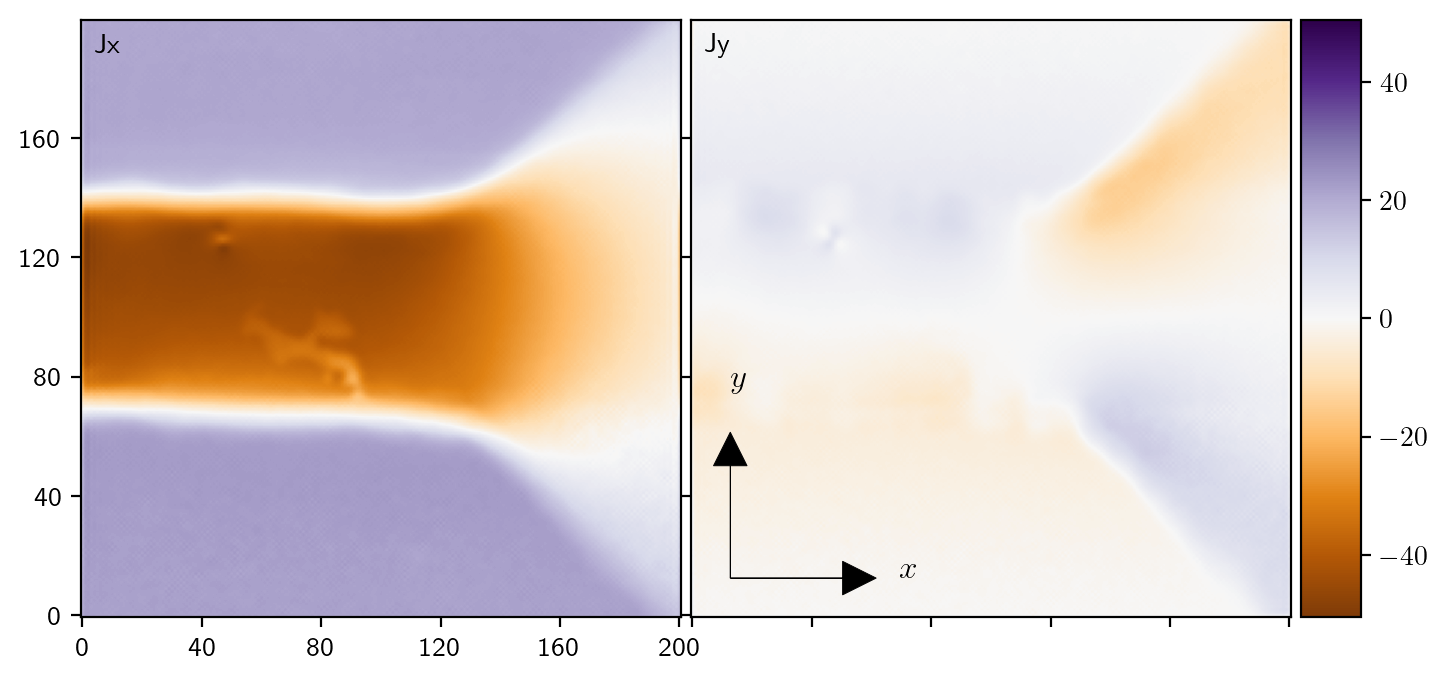

In [337]:
dataset.set_transformer(Bxyz2Jxy)
dataset.transform_data()


plot_n_components(
    dataset.transformed_target, 
    symmetric=True, 
    labels=["Jx", "Jy"], 
    cmap="PuOr")


## Now we will try to reconstruct the current density using a neural network.

In [347]:
from magrec.method.CNN import CNN
from magrec.models.Jxy import Jxy

Model = Jxy(dataset, "L1")
FittingMethod = CNN(Model, dataset)
FittingMethod.prepare_fit()

Number of sources: 2
Number of targets: 3


In [348]:
FittingMethod.fit(n_epochs=100)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 25 but got size 26 for tensor number 1 in the list.

: 